In [1]:
import numpy as np

import torch
import torch.nn as nn
import pandas
from torch.utils.data import DataLoader,Dataset, random_split, Subset
from matplotlib.pylab import plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
discharge_capacities = np.load(r"./Datasets/discharge_capacity.npy", allow_pickle=True)
discharge_capacities = discharge_capacities.tolist()

In [3]:
channels  = 7

In [5]:


def get_data(discharge_capacities,percentage,window_size,stride,channels,type):

    train_data =[]
    FPC_data  =[]
    name = 0
    test_data = []
    
    if(type == "train"):
        
        for battery in discharge_capacities:
            a = len(FPC_data)
            battery = np.asarray(battery)
            
            battery_name = 'battery' + str(name)
            name = name+1
            
            # Taking inital x% as input and giving the output as 1
            i= 0
            target = 1
            while(i+stride+window_size <= int(percentage*len(battery[0])) and len(battery[0][i:i+window_size]) == window_size):
                train_data.append((battery[:channels,i:i+window_size], target,battery_name ))
                i = i+stride

            # Taking inputs in the middle for FPC
            i = int(percentage*len(battery[0]))
            target = -1
            while(i+stride+window_size <= int((1-percentage)*len(battery[0])) and len(battery[0][i:i+window_size]) == window_size):
                FPC_data.append((battery[:channels,i:i+window_size], target,battery_name))
                i = i+stride

            # Taking last x% as input and giving the output as 0
            i = int((1-percentage)*len(battery[0]))
            target = 0
            while(i+stride <= len(battery[0]) and len(battery[0][i:i+window_size]) == window_size):
                train_data.append((battery[:channels,i:i+window_size], target ,battery_name))
                i = i+stride
            # print(len(FPC_data)-a, len(battery[0]), len(FPC_data)-a- .90*len(battery[0]))

        return train_data,FPC_data

    else:
        name = 100
        for battery in discharge_capacities:
            battery = np.asarray(battery)
            i= 0
            
            battery_name = 'test_battery' + str(name)
            name = name+1
            while(i+stride <= len(battery[0]) and len(battery[0][i:i+window_size]) == window_size):
                test_data.append((battery[:channels,i:i+window_size], 1,battery_name))
                i = i+stride

        return test_data


In [6]:
class battery_dataloader(Dataset):
    
    def __init__(self,data):
        self.data = data
    

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,idx):
        inp =  torch.tensor(self.data[idx][0]).float()
        output = torch.tensor(self.data[idx][1]).float()
        name = self.data[idx][2]
        return inp, output,name 
   


In [7]:
percentage  = 0.10  # 5 percent data
window_size = 50    # window size
stride = 1          # stride

train_data,FPC_data = get_data(discharge_capacities[:100],percentage,window_size,stride,channels,type = "train")
test_data  = get_data(discharge_capacities[100:],None,window_size,stride,channels,type= "test")

obj_train  = battery_dataloader(train_data)
obj_FPC  = battery_dataloader(FPC_data)
obj_test  = battery_dataloader(test_data)


train_dataloader = DataLoader(obj_train, batch_size=8,shuffle=True)
FPC_dataloader   = DataLoader(obj_FPC,batch_size=1,shuffle=False)
test_dataloader = DataLoader(obj_test, batch_size=1,shuffle=False)


In [8]:

print("Number of Channels  :", channels)
print("Shape of a batch    :",next(iter(train_dataloader))[0].shape)

Number of Channels  : 7
Shape of a batch    : torch.Size([8, 7, 50])


In [9]:
import math
class CNN_Model(nn.Module):
    
    def __init__(self,input_size, channels):
        super(CNN_Model, self).__init__()
        self.name = "CNN"
        filter_size_1 = 21
        filter_size=21
        
        self.conv1 = nn.Conv1d(channels,16,kernel_size = filter_size_1, stride=1,padding=filter_size_1//2)
        self.batch_norm1 = nn.BatchNorm1d(16)
        self.max_pool1 = nn.MaxPool1d(2)
        

        self.conv2 = nn.Conv1d(16,32, kernel_size = filter_size_1, stride = 1,padding=filter_size_1 //2)
        self.batch_norm2 = nn.BatchNorm1d(32)
        self.max_pool2 = nn.MaxPool1d(2)

        self.conv3 = nn.Conv1d(32,64, kernel_size = filter_size, stride = 1,padding=filter_size //2)
        self.batch_norm3 = nn.BatchNorm1d(64)
        self.max_pool3 = nn.MaxPool1d(2)

       
        self.flatten_size = 128*math.floor(input_size/(2*2*2*2))
        self.flatten = nn.Flatten(start_dim=1)
        
        self.Linear1 = nn.Linear(self.flatten_size, input_size)
        self.batch_norm_linear = nn.BatchNorm1d(input_size)
        # self.a = nn.Linear()
        self.Linear2 = nn.Linear(input_size,1)
        
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.gelu = nn.GELU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.3)
        # print(self.flatten_size)
        
        
        
    def forward(self,x):
        # x= x.view(x.shape[0],1,x.shape[1])
        
        out = self.conv1(x)
        out = self.relu(out)
        out = self.batch_norm1(out)
        out = self.dropout(out)
        out = self.max_pool1(out)

        out = self.conv2(out)
        out = self.relu(out)
        out = self.batch_norm2(out)
        out = self.dropout(out)
        out = self.max_pool2(out)   

        out = self.conv3(out)
        out = self.relu(out)
        out = self.batch_norm3(out)
        out = self.dropout(out)
        out = self.max_pool3(out) 

        out = self.flatten(out)
        
        out = self.Linear1(out)  
        out = self.Linear2(out)

        out = self.sigmoid(out)
        return out

In [10]:
from torchmetrics.classification import BinaryAccuracy


def train_model(window_size,channels,train_dataloader,epochs):

    model = CNN_Model(window_size,channels)
    learning_rate = 0.001
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, betas= (0.9, 0.99))
    criterion = nn.BCELoss()
    metric = BinaryAccuracy()

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)

   

    for epoch in range(epochs):
        total_loss = 0
        model.train()
        model.requires_grad_(True)
        acc = 0
        total_loss = 0
        total = 0
        total_batces = 0
        for x, y ,_ in train_dataloader:
            
            x = x.to(device=device)
            y = y.to(device=device)
            out = model(x)
            acc += metric(out, y.unsqueeze(1))

            loss = criterion(out,y.unsqueeze(1))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * x.size()[0]
            total += x.size()[0]
            total_batces +=1


        print("Loss = {} Accuarcy ={}".format(total_loss/total,acc/total_batces))
    return model



In [11]:
model = train_model(window_size, channels,train_dataloader,20) 

Loss = 0.24456481468439534 Accuarcy =0.892171323299408
Loss = 0.0693855149302663 Accuarcy =0.9782127141952515
Loss = 0.040965099737052826 Accuarcy =0.9879985451698303
Loss = 0.039429943570672726 Accuarcy =0.9874445796012878
Loss = 0.023231004604775413 Accuarcy =0.993353009223938
Loss = 0.02750526251465745 Accuarcy =0.9922451972961426
Loss = 0.026934264778838483 Accuarcy =0.9939069151878357
Loss = 0.038273829468645826 Accuarcy =0.9920605421066284
Loss = 0.021003556675284026 Accuarcy =0.9929837584495544
Loss = 0.016559923390536566 Accuarcy =0.9937223196029663
Loss = 0.01937224243271602 Accuarcy =0.9959379434585571
Loss = 0.02556575113626841 Accuarcy =0.9944608807563782
Loss = 0.020351599188897652 Accuarcy =0.9951993823051453
Loss = 0.023359387446125108 Accuarcy =0.9915066361427307
Loss = 0.02733802859131841 Accuarcy =0.9929837584495544
Loss = 0.01683173071294491 Accuarcy =0.9953840374946594
Loss = 0.019394887110686397 Accuarcy =0.9948301315307617
Loss = 0.01879958960662397 Accuarcy =0.99

In [37]:
def get_fpc_window(pred):
    initial = pred[0]
    window = -1
    for i in range(0,len(pred)-1):
        if(pred[i+1]!=initial):
            window =i
        initial = pred[i+1]
    return window+1


def get_fpc_window(pred,patiance):
    
    count = 0
    for window,pred_value in enumerate(pred):
        if(pred_value.item() ==0):
            count =  count +1
        if(pred_value.item() ==1):
            count =0
        if(count == patiance):
            return window-patiance
    
                   

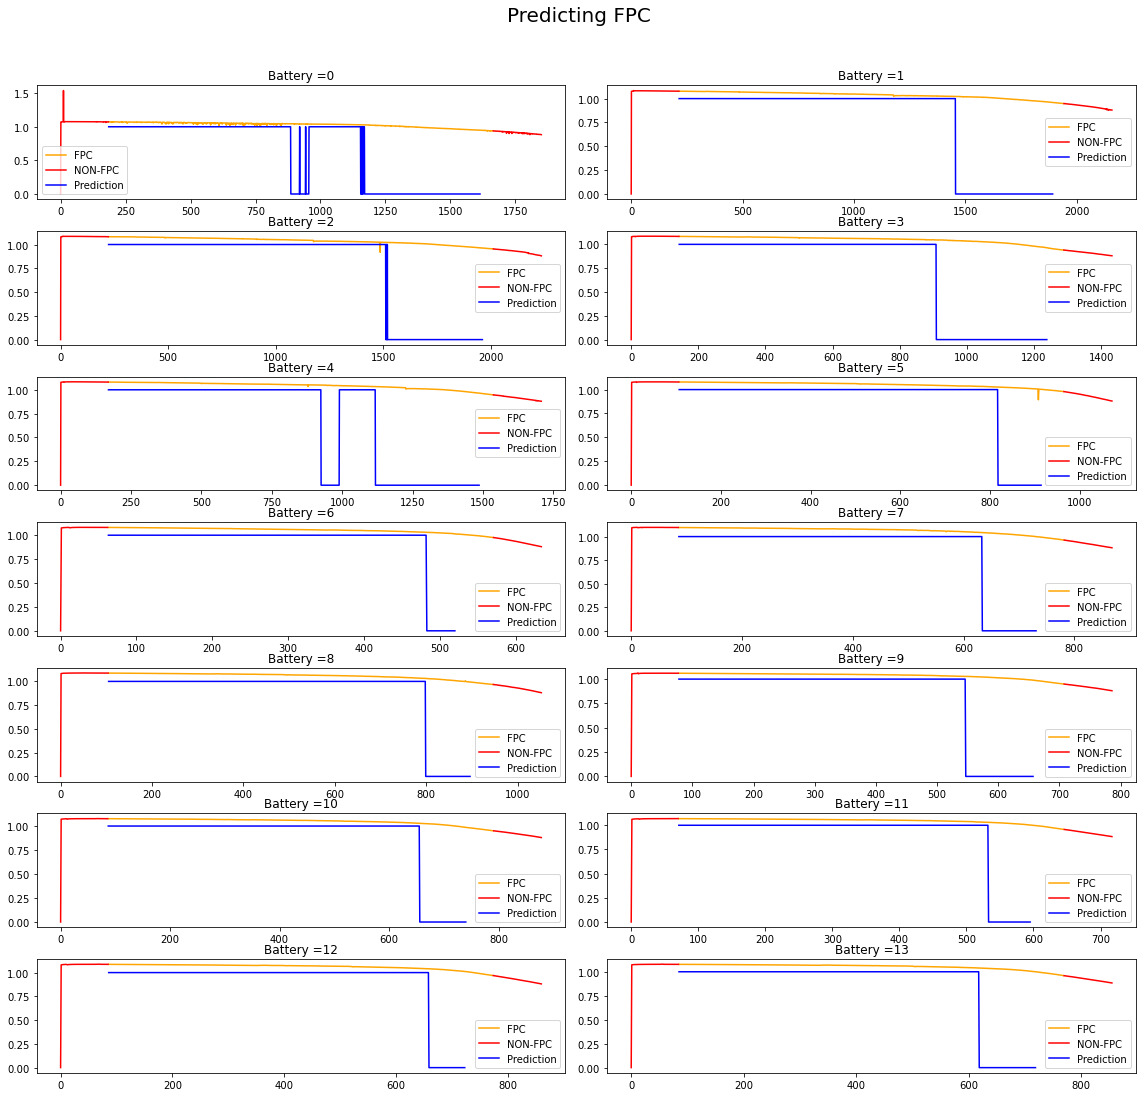

In [38]:
model.eval()
batteries_to_show = [i for i in range(0,14)]
window = 0
pred = []

rows = 2
col  = 7
fig, ax = plt.subplots(col,rows,figsize=(16,16))
ax = ax.flatten()
plt.suptitle("Predicting FPC", fontsize = 20)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
change_percentage_train = []
for ind,battery in enumerate(batteries_to_show):
    pred = []
    count = 0
    for x, y ,_ in FPC_dataloader:
        initial_count = count
        if(_[0][7:] == str(battery)):
            out = torch.where(model(x) > 0.5, 1, 0)
            pred.append(out)
            count = count +1
        
        if(initial_count==count and count >1):
            break
    # print(len(pred)- len(discharge_capacities[battery][0])*0.90)
    index = stride*get_fpc_window(pred, patiance=10)   # Index where the the transition occurs
    
    change_percentage = 100*discharge_capacities[battery][0][index]/max(discharge_capacities[battery][0])
    
    change_percentage_train.append(change_percentage)


    # Code for plotting the outputs
    FPC_curve = np.copy(discharge_capacities[battery][0])
    FPC_curve[1:int(percentage*len(discharge_capacities[battery][0]))] = None
    FPC_curve[int((1-percentage)*len(discharge_capacities[battery][0])):-1] = None

    Non_FPC_curve = np.copy(discharge_capacities[battery][0])
    Non_FPC_curve[int(percentage*len(discharge_capacities[battery][0])):int((1-percentage)*len(discharge_capacities[battery][0]))] = None

    pred_padded = np.pad(pred, (int(percentage*len(discharge_capacities[battery][0])), 0), constant_values=(np.nan,))

    ax[ind].plot(FPC_curve, color = 'orange')
    ax[ind].plot(Non_FPC_curve, color ='red')
    ax[ind].plot(pred_padded,color ='blue')
    ax[ind].legend(["FPC", "NON-FPC","Prediction"])
    

    ax[ind].set_title("Battery =" +str(battery))


In [39]:
np.mean(change_percentage_train)

94.6556936649807

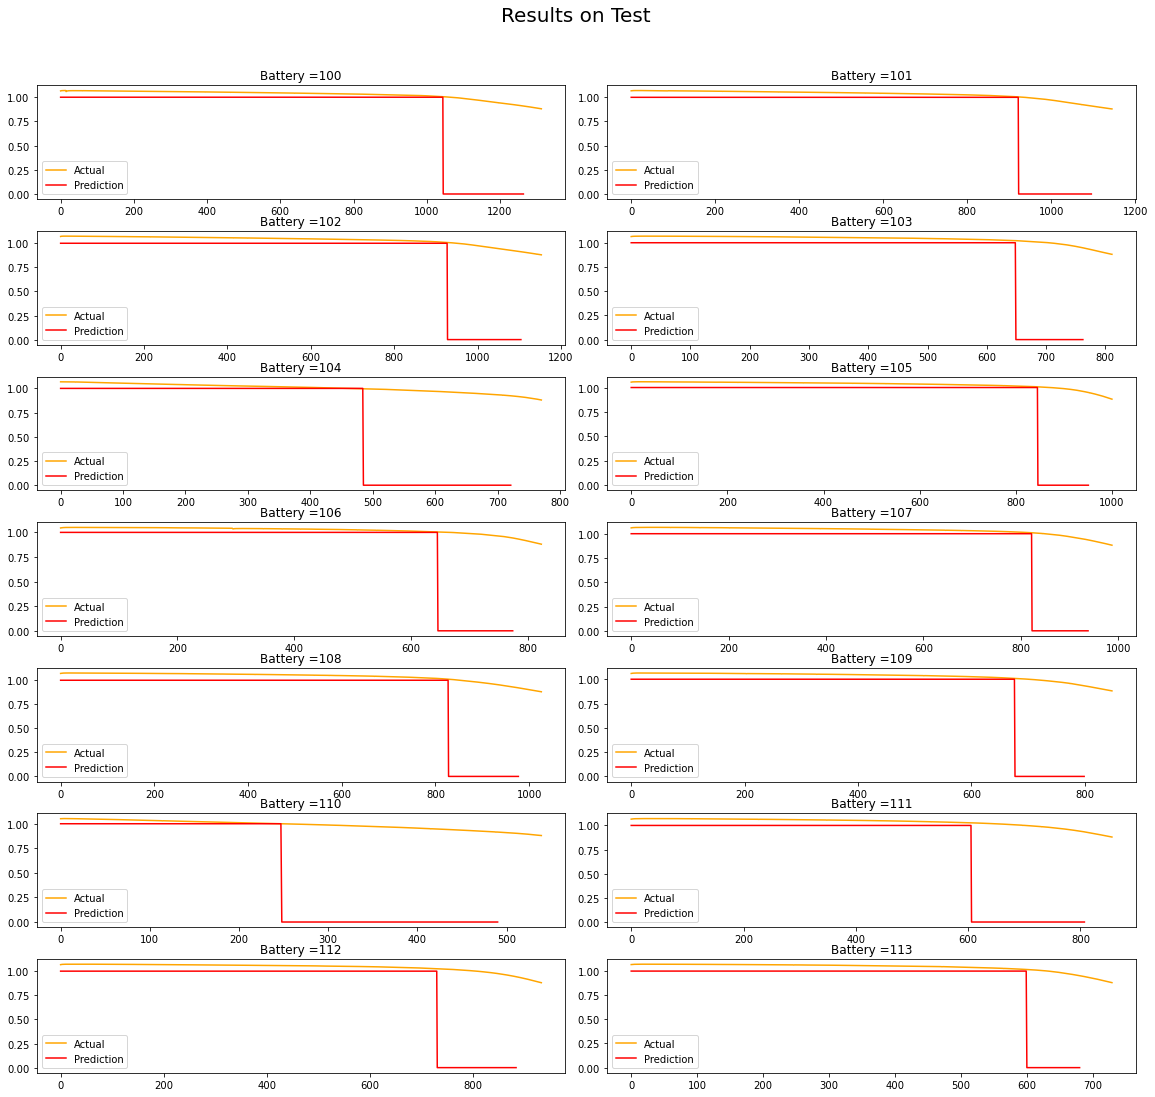

In [41]:
model.eval()
batteries_to_show = [i+100 for i in range(0,14)]
window = 0
pred = []

rows = 2
col  = 7
fig, ax = plt.subplots(col,rows,figsize=(16,16))
ax = ax.flatten()
plt.suptitle("Results on Test ", fontsize = 20)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

change_percentage_test = []

for ind,battery in enumerate(batteries_to_show):
    pred = []
    count = 0
    for x, y ,_ in test_dataloader:
        initial_count = count
        if(_[0][12:] == str(battery)):
            out = torch.where(model(x) > 0.5, 1, 0)
            pred.append(out)
            count = count +1
        if(initial_count==count and count >1):
            break

    index = stride*get_fpc_window(pred,patiance=10)   # Index where the the transition occurs
    change_percentage_test.append(100*discharge_capacities[battery][0][index]/max(discharge_capacities[battery][0]))
    

    
    ax[ind].plot(discharge_capacities[battery][0], color = 'orange')
    ax[ind].plot(pred, color ='red')
    ax[ind].legend(["Actual", "Prediction"])
    

    ax[ind].set_title("Battery =" +str(battery))


In [42]:
np.mean(change_percentage_test)

94.74056634273606

In [16]:
# no_of_channels = [1,2,3,4,5,6,7]
# changes_train = []
# changes_test = []
# epochs = 5


# for channels in no_of_channels: 
#     print("Channels used : ", channels)
#     percentage  = 0.05  # 5 percent data
#     window_size = 50    # window size
#     stride = 1          # stride

#     train_data,FPC_data = get_data(discharge_capacities[:100],percentage,window_size,stride,channels,type = "train")
#     test_data  = get_data(discharge_capacities[100:],None,window_size,stride,channels,type= "test")

#     obj_train  = battery_dataloader(train_data)
#     obj_FPC  = battery_dataloader(FPC_data)
#     obj_test  = battery_dataloader(test_data)


#     train_dataloader = DataLoader(obj_train, batch_size=8,shuffle=True)
#     FPC_dataloader   = DataLoader(obj_FPC,batch_size=1,shuffle=False)
#     test_dataloader = DataLoader(obj_test, batch_size=1,shuffle=False)
    
#     print("Shape of a batch    :",next(iter(train_dataloader))[0].shape)
#     model = train_model(window_size,channels,train_dataloader,epochs)


#     model.eval()
#     change_percentage_train = []
#     batteries =[i for i in range (100)]
#     for ind,battery in enumerate(batteries):
#         pred = []
#         for x, y ,_ in FPC_dataloader:
#             if(_[0][7:] == str(battery)):
#                 out = torch.where(model(x) > 0.5, 1, 0)
#                 pred.append(out)
#                 count = count +1
            
#             if(initial_count==count and count >1):
#                 break
#         # print(len(pred), len(discharge_capacities[battery][0])*0.90)
#         index = stride*get_fpc_window(pred)   # Index where the the transition occurs
        
#         change_percentage = 100*discharge_capacities[battery][0][index]/max(discharge_capacities[battery][0])
        
#         change_percentage_train.append(change_percentage)


    
#     batteries_to_show = [i+100 for i in range(0,24)]
#     for ind,battery in enumerate(batteries_to_show):
#         pred = []
#         count = 0
#         for x, y ,_ in test_dataloader:
#             initial_count = count
#             if(_[0][12:] == str(battery)):
#                 out = torch.where(model(x) > 0.5, 1, 0)
#                 pred.append(out)
#                 count = count +1
#             if(initial_count==count and count >1):
#                 break
        
#         index = stride*get_fpc_window(pred)   # Index where the the transition occurs
#         change_percentage_test.append(100*discharge_capacities[battery][0][index]/max(discharge_capacities[battery][0]))

#     changes_train.append(np.mean(change_percentage_train))
#     changes_test.append(np.mean(change_percentage_test))

# import pandas as pd
# results = pd.DataFrame([changes_train,changes_test], columns=no_of_channels, index=["Train","Test"])
# results.to_csv('channel_analysis.csv')

In [36]:
patiance = 16
count = 0
for j,i in enumerate(pred):
    if(i.item() ==0):
        count =  count +1

    if(i.item() ==1):
        count =0
    if(count == patiance):
        print(j-patiance)


533


In [30]:
pred-pa

[tensor([[1]]),
 tensor([[1]]),
 tensor([[1]]),
 tensor([[1]]),
 tensor([[1]]),
 tensor([[1]]),
 tensor([[1]]),
 tensor([[1]]),
 tensor([[1]]),
 tensor([[1]]),
 tensor([[1]]),
 tensor([[1]]),
 tensor([[1]]),
 tensor([[1]]),
 tensor([[1]]),
 tensor([[1]]),
 tensor([[1]]),
 tensor([[1]]),
 tensor([[1]]),
 tensor([[1]]),
 tensor([[1]]),
 tensor([[1]]),
 tensor([[1]]),
 tensor([[1]]),
 tensor([[1]]),
 tensor([[1]]),
 tensor([[1]]),
 tensor([[1]]),
 tensor([[1]]),
 tensor([[1]]),
 tensor([[1]]),
 tensor([[1]]),
 tensor([[1]]),
 tensor([[1]]),
 tensor([[1]]),
 tensor([[1]]),
 tensor([[1]]),
 tensor([[1]]),
 tensor([[1]]),
 tensor([[1]]),
 tensor([[1]]),
 tensor([[1]]),
 tensor([[1]]),
 tensor([[1]]),
 tensor([[1]]),
 tensor([[1]]),
 tensor([[1]]),
 tensor([[1]]),
 tensor([[1]]),
 tensor([[1]]),
 tensor([[1]]),
 tensor([[1]]),
 tensor([[1]]),
 tensor([[1]]),
 tensor([[1]]),
 tensor([[1]]),
 tensor([[1]]),
 tensor([[1]]),
 tensor([[1]]),
 tensor([[1]]),
 tensor([[1]]),
 tensor([[1]]),
 tensor(